## Importing libraries

In [16]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from scipy import signal
import cv2

## Loading image

In [2]:
main_img = plt.imread('books.jpg')

In [3]:
main_img.shape

(1280, 960, 3)

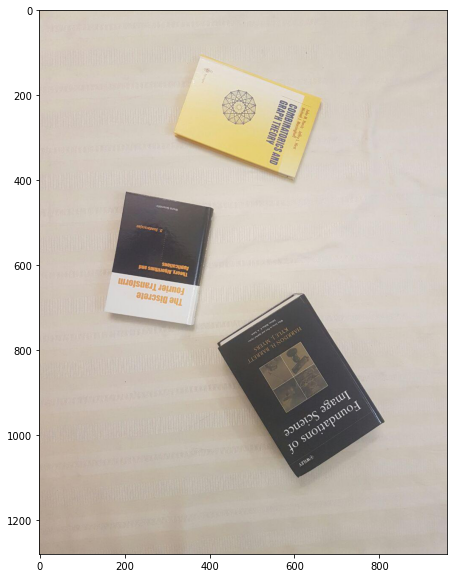

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(main_img);

## Selecting corners of a book

The order of corners should be the same as below:
1. Top-Left of the book
2. Top-Right of the book
3. Bottom-Right of the book
4. Bottom-Left of the book

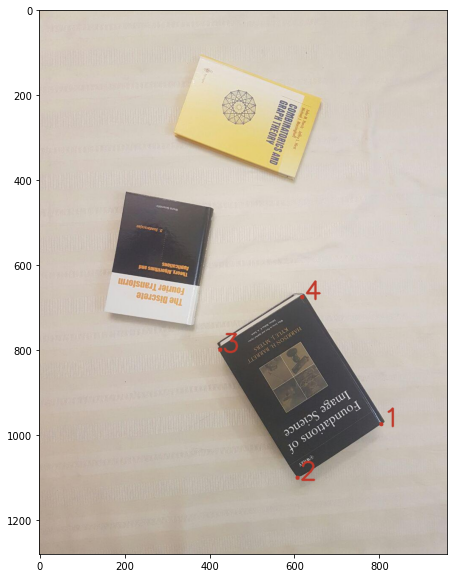

In [5]:
def draw_circle(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        color = (43, 57, 192)
        cv2.circle(img, (x, y), 5, color, -1)
        cv2.putText(img, str(len(coords)+1), (x+5, y+5), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 4, cv2.LINE_AA)
        cv2.imshow('image', img)
        coords.append([x, y])
        if len(coords) == 4:
            cv2.destroyAllWindows()

coords = []
img = cv2.imread('books.jpg')
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_circle)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [6]:
coords = np.array(coords, dtype=np.float32)
coords

array([[ 805.,  974.],
       [ 608., 1100.],
       [ 426.,  799.],
       [ 619.,  675.]], dtype=float32)

## Find Transformation

In [7]:
def points_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [8]:
i_range = points_distance(coords[1], coords[2]).astype(np.int32)
j_range = points_distance(coords[0], coords[1]).astype(np.int32)

new_coords = np.array([
    [0, 0],
    [j_range, 0],
    [j_range, i_range],
    [0, i_range],
], dtype=np.float32)

In [17]:
T = cv2.getPerspectiveTransform(coords, new_coords)

## Warping with library

In [18]:
res = cv2.warpPerspective(main_img, T, (j_range, i_range))

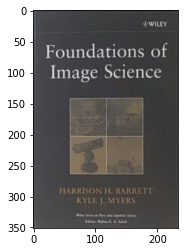

In [19]:
plt.imshow(res);

## Warping from scratch

This function is the implementation of the below image 

![Warping method](warping_method.png)

In [20]:
def f(im, xa, yb):
    x, y = np.floor(xa).astype(np.int32), np.floor(yb).astype(np.int32)
    a, b = xa - x, yb -  y
    
    result = np.array([
        np.array([1-a, a]).reshape(1, 2) @
        np.array([[im[x, y, i], im[x, y+1, i]], [im[x+1, y, i], im[x+1, y+1, i]]]).reshape(2, 2) @
        np.array([1-b, b]).reshape(2, 1)
    for i in range(3)], dtype=np.float32).flatten()

    return result

In [21]:
T_inv = np.linalg.inv(T)

res = np.zeros((i_range, j_range, 3), dtype=np.float32)
for i in range(i_range):
    for j in range(j_range):
        coord = T_inv @ np.array([j, i, 1]).reshape(3, 1)
        coord = coord / coord[2]
        res[i, j] = f(main_img, coord[1], coord[0])

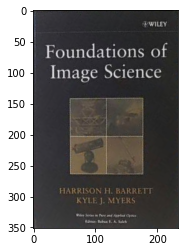

In [22]:
def normalize_between_zero_to_one(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

plt.imshow(normalize_between_zero_to_one(res));